In [1]:
## Post-processing of single interferogram from ISCE/stripmapApp.py
# 1. extract metadata from ISCE xml file into PYSAR/ROIPAC format
# 2. load geometry files into geometryRadar.h5 for geocoding
# 3. geocodeing
# 4. select reference point and masking

% matplotlib inline
import os
import time
from datetime import datetime as dt
from decimal import Decimal
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pysar.utils import readfile, writefile, utils as ut

work_dir = os.path.expanduser("~/insarlab/Others/Shuangyu/")

proj_name = "KoaeCskDT165"
date12 = "20120507_20120624"

#proj_name = "KoaeCskAT10"
#date12 = "20120529_20120617"

os.chdir(work_dir)
print('Go to directory:', work_dir)
geom_dir = os.path.join(work_dir, proj_name, 'geometry'); geom_file = os.path.join(geom_dir, 'geometryRadar.h5')
ifg_dir = os.path.join(work_dir, proj_name, 'interferogram')
geo_dir = os.path.join(work_dir, proj_name, 'GEOCODE')
if not os.path.isdir(geo_dir):
    os.makedirs(geo_dir)
    print('create directory:', geo_dir)

# manual setup
SNWE = "19.325 19.365 -155.31 -155.26"
ref_lat = "19.332"
ref_lon = "-155.308"
step = "0.0000925926"   #10m

# auto setup
unw_file = 'geo_{}.unw'.format(date12)
con_file = 'geo_{}.unw.conncomp'.format(date12)
cor_file = 'geo_{}.cor'.format(date12)
in_files  = [os.path.join(ifg_dir, i) for i in ['filt_topophase.unw', 'filt_topophase.unw.conncomp', 'phsig.cor']]
out_files = [os.path.join(geo_dir, i) for i in [unw_file, con_file, cor_file]]

Go to directory: /Users/yunjunz/insarlab/Others/Shuangyu/


In [2]:
## prepare
## 1. Load ISCE/stripmapApp.py geometry file into geometryRadar.h5 file
if not os.path.isfile(geom_file):
    # prepare metadata
    xml_file = os.path.join(work_dir, proj_name, '{}_slc_crop.xml'.format(date12.split('_')[0]))
    cmd = 'prep_isce.py -m {} -g ./geometry'.format(xml_file)
    print(cmd)
    !{cmd}

    # load into HDF5 file
    lat_file = os.path.join(work_dir, proj_name, 'geometry/lat.rdr')
    lon_file = os.path.join(work_dir, proj_name, 'geometry/lon.rdr')
    los_file = os.path.join(work_dir, proj_name, 'geometry/los.rdr')
    meta = readfile.read_attribute(lat_file)
    dsDict = {}
    dsDict['latitude'] = readfile.read(lat_file)[0]
    dsDict['longitude'] = readfile.read(lon_file)[0]
    dsDict['incidenceAngle'] = readfile.read(los_file, datasetName='incidenceAngle')[0]
    writefile.write(dsDict, out_file=geom_file, metadata=meta)
else:
    print('{} exists.'.format(geom_file))

## 2. update metadata for ifgram files
for in_file in in_files:
    meta_file = os.path.join(work_dir, proj_name, 'data.rsc')
    atr = readfile.read_roipac_rsc(meta_file)
    atr.update(readfile.read_isce_xml(in_file+'.xml'))
    writefile.write_roipac_rsc(atr, in_file+'.rsc', print_msg=True)

/Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/geometry/geometryRadar.h5 exists.
write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw.rsc
write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw.conncomp.rsc
write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/interferogram/phsig.cor.rsc


In [3]:
# geocoding
for in_file, out_file in zip(in_files, out_files):
    cmd = "geocode.py {f} -l {l} -b {b} -o {o} --lat-step -{s} --lon-step {s}".format(f=in_file,
                                                                                      l=geom_file, 
                                                                                      b=SNWE,
                                                                                      o=out_file,
                                                                                      s=step)
    print(cmd)
    !{cmd}

geocode.py /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw -l /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/geometry/geometryRadar.h5 -b 19.325 19.365 -155.31 -155.26 -o /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw --lat-step -0.0000925926 --lon-step 0.0000925926
output pixel size in (lat, lon) in degree: (-9.25926e-05, 9.25926e-05)
output area extent in (S N W E) in degree: (19.325, 19.365, -155.31, -155.26)
--------------------------------------------------
resampling file: /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/interferogram/filt_topophase.unw
reading filt_topophase from filt_topophase.unw ...
nearest resampling with kd_tree (0 segments) ...
writing /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw
write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw.rsc
time used: 00 mins 1.4 secs.

geocode.py /Users/yunjun

In [4]:
## adjust metadata to ROIPAC style
rsc_file = os.path.join(work_dir, proj_name, 'ROIPAC/geo_{}.unw.rsc'.format(date12))
atr0 = readfile.read_roipac_rsc(rsc_file)

for out_file in out_files:
    rsc_file = out_file+'.rsc'
    atr = readfile.read_roipac_rsc(rsc_file)
    atr['XMIN'] = '0'
    atr['XMAX'] = str(int(atr['WIDTH'])-1)
    atr['YMIN'] = '0'
    atr['YMAX'] = str(int(atr['FILE_LENGTH'])-1)
    atr['DATE'] = date12.split('_')[0]
    atr['DATE12'] = date12
    
    dates = [dt(*time.strptime(i, "%Y%m%d")[0:5]) for i in date12.split('_')]
    yr_diff = (dates[1] - dates[0]).days / 365.25
    atr['TIME_SPAN_YEAR'] = str(yr_diff)
    
    atr['COR_THRESHOLD'] = '0'
    atr['VELOCITY'] = atr['satelliteSpeed']
    atr['ORBITNUMBER'] = '0-0'
    atr['HEIGHT'] = '{:.10E}'.format(Decimal(atr['altitude']))
    for key in ['HEADING_DEG', 'RGE_REF1', 'RGE_REF2', 'RGE_REF3', 'RGE_REF4', 'LOOK_REF1', 'LOOK_REF2', 'LOOK_REF3', 'LOOK_REF4']:
        atr[key] = atr0[key]
    writefile.write_roipac_rsc(atr, out_file=rsc_file, print_msg=True)
print('Done.')

write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw.rsc
write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw.conncomp.rsc
write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.cor.rsc
Done.


reference_point.py /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.unw --lat 19.332 --lon -155.308 --write-data
--------------------------------------------------
input reference point in lat/lon: (19.332, -155.308)
input reference point in y/x: (357, 22)
--------------------------------------------------
writing >>> /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw
writing /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw
write /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw.rsc
Done.
mask.py /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded.unw -m /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624.cor -t 0.4 -o /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded_masked.unw
mask out pixels with value < 0.4 in m

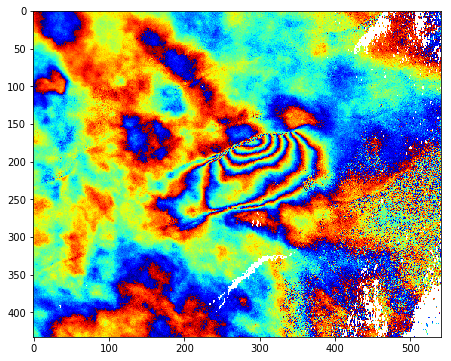

In [9]:
## select reference point
unw_file = out_files[0]
cmd = 'reference_point.py {} --lat {} --lon {} --write-data'.format(unw_file, ref_lat, ref_lon)
print(cmd)
!{cmd}

# mask
unw_file = '{}_seeded.unw'.format(os.path.splitext(out_files[0])[0])
cor_file = out_files[2]
out_file = '{}_seeded_masked.unw'.format(os.path.splitext(out_files[0])[0])
cmd = 'mask.py {} -m {} -t 0.4 -o {}'.format(unw_file, cor_file, out_file)
print(cmd)
!{cmd}

# plot
data = readfile.read(out_file)[0]
plt.figure(figsize=[10, 6])
plt.imshow(ut.wrap(data), cmap='jet', vmin=-np.pi, vmax=np.pi)
plt.show()

Input 1st file is .unw
---------------------
reading /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskAT10/GEOCODE/geo_20120529_20120617_seeded_masked.unw
heading angle: 348.1074
near   incidence angle : 37.3949 degree
far    incidence angle : 37.4760 degree
center incidence angle : 37.4354 degree
---------------------
reading /Users/yunjunz/insarlab/Others/Shuangyu/KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded_masked.unw
heading angle: 191.9016
near   incidence angle : 40.3087 degree
far    incidence angle : 40.3800 degree
center incidence angle : 40.3443 degree
---------------------
writing   vertical component to file: /Users/yunjunz/insarlab/Others/Shuangyu/AscDesc/vert.h5
delete exsited file: /Users/yunjunz/insarlab/Others/Shuangyu/AscDesc/vert.h5
create HDF5 file: /Users/yunjunz/insarlab/Others/Shuangyu/AscDesc/vert.h5 with w mode
create dataset /.unw of float64    in size of (433, 541)           with compression=None
finished writing to /Users/yunjunz/insarlab/Others/Shuangyu/

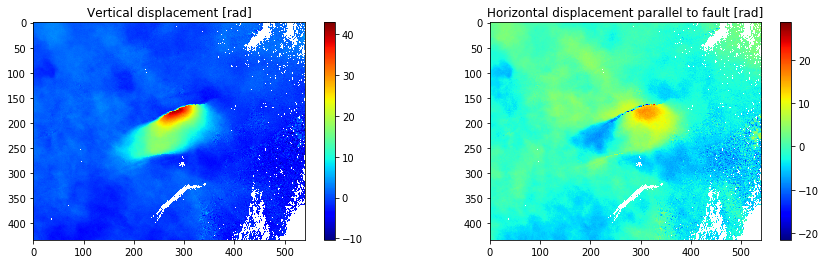

In [10]:
## project asc/desc data into vertical and fault-parallel direction.
fault_az_deg = np.arctan(824 / 385) * 180 / np.pi
asc_file = os.path.join(work_dir, 'KoaeCskAT10/GEOCODE/geo_20120529_20120617_seeded_masked.unw')
desc_file = os.path.join(work_dir, 'KoaeCskDT165/GEOCODE/geo_20120507_20120624_seeded_masked.unw')
vert_file = os.path.join(work_dir, 'AscDesc/vert.h5')
horz_file = os.path.join(work_dir, 'AscDesc/parallel.h5')
cmd = 'asc_desc2horz_vert.py {} {} --az {} -o {} {}'.format(asc_file, desc_file, fault_az_deg, vert_file, horz_file)
!{cmd}

## plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[15, 4])
im1 = axs[0].imshow(h5py.File(vert_file, 'r')['.unw'][:], cmap='jet');  fig.colorbar(im1, ax=axs[0]); axs[0].set_title('Vertical displacement [rad]')
im2 = axs[1].imshow(h5py.File(horz_file, 'r')['.unw'][:], cmap='jet');  fig.colorbar(im2, ax=axs[1]); axs[1].set_title('Horizontal displacement parallel to fault [rad]')
plt.show()